## Import Libraries

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

## Load Data

In [ ]:
if not os.path.exists("family_data"):
    !git clone https://github.com/anyelyra/family_data.git

if not os.path.exists("family_data/family_photo") and os.path.exists("family_data/family_photo.zip"):
    with zipfile.ZipFile("family_data/family_photo.zip", 'r') as zip_ref:
        zip_ref.extractall("family_data")

DATA_DIR = "family_data/family_photo"
LABEL_FILE = "family_data/family_label.xlsx"
IMG_SIZE = 160

print("Isi folder keluarga:", os.listdir(DATA_DIR))

Cloning into 'family_data'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 9.89 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Isi folder keluarga: ['beyonce_family', 'james_family', 'beckham_family', 'reynolds_family', 'hemsworth_family', 'baswedan_family', 'lesti_family', 'ganjar_family', 'raffi_family', 'kardashian_family', 'obama_family', 'sprouse_family', 'krasinski_family', 'schwarzenegger_family', 'anang_family', 'will_smith_family', 'titi_family']


In [ ]:
DATA_DIR = "family_data/family_photo"
LABEL_FILE = "family_data/family_label.xlsx"
IMG_SIZE = 160

df = pd.read_excel(LABEL_FILE)
print("Label file loaded, contoh data:")
print(df.head())

def find_family_folder(family_id):
    for folder_name in os.listdir(DATA_DIR):
        if family_id.lower() in folder_name.lower():
            return os.path.join(DATA_DIR, folder_name)
    return None

def find_image_path(fam_folder, person):
    person_clean = person.strip().lower()
    files = os.listdir(fam_folder)
    for f in files:
        if person_clean in f.lower():
            return os.path.join(fam_folder, f)
    return None

def load_and_resize_image(path, size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    return img

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_cnn = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])
model_cnn.trainable = False

Label file loaded, contoh data:
          family_id person1   person2 relationship
0  hemsworth_family    luke      liam      saudara
1  hemsworth_family    luke     chris      saudara
2  hemsworth_family    liam     chris      saudara
3   reynolds_family    ryan     blake  suami-istri
4    beckham_family   david  victoria  suami-istri
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Preprocess CNN & Ekstraksi Fitur

In [ ]:
X = []
y = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fam_folder = find_family_folder(row['family_id'])
    if fam_folder is None:
        print(f"Folder keluarga tidak ditemukan: {row['family_id']}")
        continue

    img1_path = find_image_path(fam_folder, row['person1'])
    img2_path = find_image_path(fam_folder, row['person2'])

    if img1_path is None or img2_path is None:
        print(f"Gambar tidak ditemukan: {row['person1']} atau {row['person2']} di {fam_folder}")
        continue

    img1 = load_and_resize_image(img1_path)
    img2 = load_and_resize_image(img2_path)

    if img1 is None or img2 is None:
        print(f"Error load gambar: {img1_path} atau {img2_path}")
        continue

    img1_pre = preprocess_input(np.expand_dims(img1, axis=0))
    img2_pre = preprocess_input(np.expand_dims(img2, axis=0))

    feat1 = model_cnn.predict(img1_pre, verbose=0)[0]
    feat2 = model_cnn.predict(img2_pre, verbose=0)[0]

    combined_feat = np.concatenate([feat1, feat2])
    X.append(combined_feat)
    y.append(row['relationship'])

print(f"Jumlah data yang berhasil dimuat: {len(X)}")

100%|██████████| 80/80 [00:24<00:00,  3.24it/s]

Jumlah data yang berhasil dimuat: 80


In [ ]:
X = np.array(X)
y = np.array(y)

print("Dataset siap untuk training!")

Dataset siap untuk training!


## Label Encoding & Model Training

In [ ]:
if len(X) == 0:
    print("Tidak ada data valid.")
else:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    train_index, test_index = train_test_split(
        np.arange(len(y_encoded)),
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )

    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y_encoded, np.arange(len(y_encoded)),
        test_size=0.2, random_state=42, stratify=y_encoded
    )

    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)

## Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6875
Classification report:
              precision    recall  f1-score   support

   ayah-anak       0.50      0.67      0.57         3
    ibu-anak       0.75      0.75      0.75         4
     saudara       0.83      0.83      0.83         6
 suami-istri       0.50      0.33      0.40         3

    accuracy                           0.69        16
   macro avg       0.65      0.65      0.64        16
weighted avg       0.69      0.69      0.68        16



## Prediction Pairs

In [ ]:
def show_prediction_pairs(df, X_test, y_test, y_pred, label_encoder, test_idx, data_dir=DATA_DIR, img_size=IMG_SIZE, n=5):
    plt.figure(figsize=(8, n * 4))

    for i in range(min(n, len(X_test))):
        idx = test_idx[i]
        row = df.iloc[idx]

        fam_folder = None
        for folder_name in os.listdir(data_dir):
            if row['family_id'].lower() in folder_name.lower():
                fam_folder = os.path.join(data_dir, folder_name)
                break
        if fam_folder is None:
            print(f"Folder keluarga tidak ditemukan: {row['family_id']}")
            continue

        img1_path = None
        img2_path = None
        files = os.listdir(fam_folder)
        for f in files:
            if row['person1'].strip().lower() in f.lower():
                img1_path = os.path.join(fam_folder, f)
            if row['person2'].strip().lower() in f.lower():
                img2_path = os.path.join(fam_folder, f)

        if img1_path is None or img2_path is None:
            print(f"Gambar tidak ditemukan untuk pasangan: {row['person1']}, {row['person2']}")
            continue

        img1 = cv2.imread(img1_path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (img_size, img_size))

        img2 = cv2.imread(img2_path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img2, (img_size, img_size))

        true_label = label_encoder.inverse_transform([y_test[i]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[i]])[0]

        plt.subplot(n, 2, 2*i+1)
        plt.imshow(img1)
        plt.axis('off')
        if i == 0:
            plt.title("Gambar 1")
        plt.text(0, img_size + 5, f"True: {true_label}\nPred: {pred_label}", fontsize=10, color='blue')

        plt.subplot(n, 2, 2*i+2)
        plt.imshow(img2)
        plt.axis('off')
        if i == 0:
            plt.title("Gambar 2")
        plt.text(0, img_size + 5, f"True: {true_label}\nPred: {pred_label}", fontsize=10, color='blue')

    plt.tight_layout()
    plt.show()

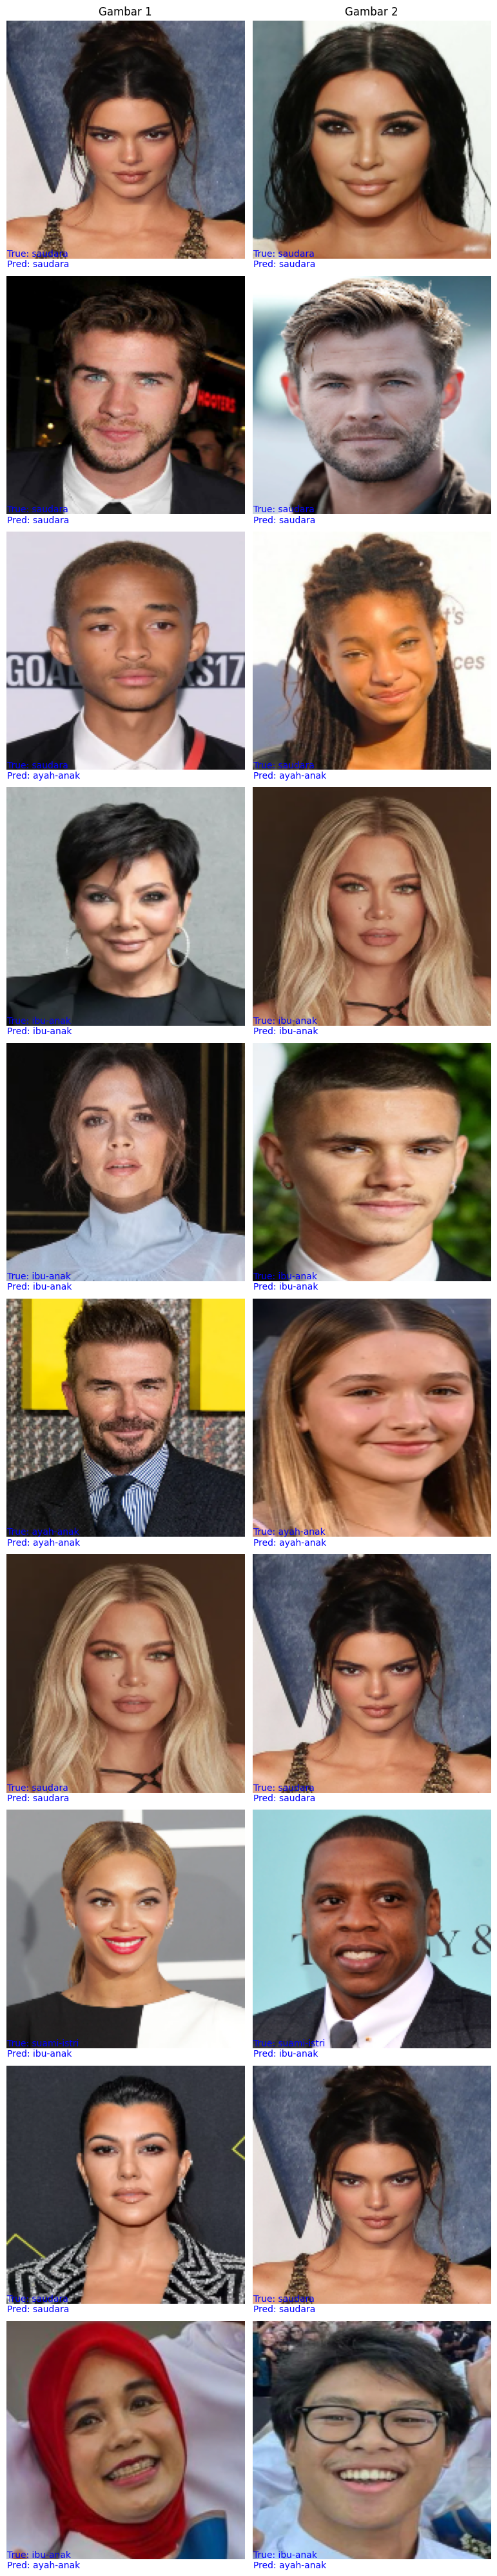

In [ ]:
show_prediction_pairs(df, X_test, y_test, y_pred, label_encoder=le, test_idx=test_idx, n=10)

## (Another Trial) Ensemble SVC & XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

ensemble = VotingClassifier(
    estimators=[('svm', svm_model), ('xgb', xgb_model)],
    voting='soft'
)

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8125
Classification report:
               precision    recall  f1-score   support

   ayah-anak       0.50      0.50      0.50         2
    ibu-anak       0.86      1.00      0.92         6
     saudara       1.00      0.86      0.92         7
 suami-istri       0.00      0.00      0.00         1

    accuracy                           0.81        16
   macro avg       0.59      0.59      0.59        16
weighted avg       0.82      0.81      0.81        16



### Cross Validation for 'Ensemble SVM & XGBoost'

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ensemble, X, y, cv=5)
print(f"Cross-val accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")

Cross-val accuracy: 0.46 (+/- 0.12)
